In [3]:
! source /home/ollie/qigao001/miniconda3/bin/activate
! conda activate training
! which python


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.


/home/ollie/qigao001/miniconda3/envs/training/bin/python


In [5]:
import pyfesom2 as pf
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs

In [8]:


def ticks_labels(
    xmin, xmax, ymin, ymax, xspacing, yspacing
    ):
    '''
    # input ----
    xmin, xmax, ymin, ymax: range of labels
    xspacing: spacing of x ticks
    yspacing: spacing of y ticks
    
    # output ----
    xticks_pos, xticks_label, yticks_pos, yticks_label
    '''
    
    import numpy as np
    
    # get the x ticks
    xticks_pos = np.arange(xmin, xmax + xspacing, xspacing)
    if not isinstance(xspacing, int):
        xticks_pos = np.around(xticks_pos, 1)
    
    # Associate with '° W', '°', and '° E'
    xticks_label = [''] * len(xticks_pos)
    for i in np.arange(len(xticks_pos)):
        if (abs(xticks_pos[i]) == 180) | (xticks_pos[i] == 0):
            xticks_label[i] = str(abs(xticks_pos[i])) + '°'
        elif xticks_pos[i] < 0:
            xticks_label[i] = str(abs(xticks_pos[i])) + '° W'
        elif xticks_pos[i] > 0:
            xticks_label[i] = str(xticks_pos[i]) + '° E'
    
    # get the y ticks
    yticks_pos = np.arange(ymin, ymax + yspacing, yspacing)
    if not isinstance(yspacing, int):
        yticks_pos = np.around(yticks_pos, 1)
    
    # Associate with '° N', '°', and '° S'
    yticks_label = [''] * len(yticks_pos)
    for i in np.arange(len(yticks_pos)):
        if yticks_pos[i] < 0:
            yticks_label[i] = str(abs(yticks_pos[i])) + '° S'
        if yticks_pos[i] == 0:
            yticks_label[i] = str(yticks_pos[i]) + '°'
        if yticks_pos[i] > 0:
            yticks_label[i] = str(yticks_pos[i]) + '° N'
    
    return xticks_pos, xticks_label, yticks_pos, yticks_label


def polar_scale_bar(
    ax, bars = None, length = None, location = None,
    barheight = None, linewidth = None, col = 'black', transform = None,
    middle_label=None, fontcolor='black', vline = 1400):
    '''
    ax: the axes to draw the scalebar on.
    bars: the number of subdivisions
    length: in [km].
    location: left side of the scalebar in axis coordinates.
    barheight: in [km]
    linewidth: the thickness of the scalebar.
    col: the color of the scale bar
    middle_label: whether to plot the middle label
    '''
    
    import cartopy.crs as ccrs
    from matplotlib.patches import Rectangle
    
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent()
    
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]
    
    # Plot the scalebar chunks
    barcol = 'white'
    
    for i in range(0, bars):
        # Generate the x coordinate for the left of ith bar
        barleft_x = sbx + i * length * 1000 / bars
        
        # plot the chunk
        ax.add_patch(
            Rectangle((barleft_x, sby),
                      length * 1000 / bars, barheight * 1000, ec = 'black',
                      color = barcol, lw = linewidth,
                      transform=transform, clip_on=False))
        
        # alternate the colour
        if barcol == 'white':
            barcol = col
        else:
            barcol = 'white'
        # Plot the scalebar label for that chunk
        if i == 0 or middle_label:
            ax.text(barleft_x, sby + barheight * 1200,
                    str(round(i * length / bars)), transform=transform,
                    horizontalalignment='center', verticalalignment='bottom',
                    color=fontcolor)
        
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000 * 1.1
    # Plot the last scalebar label
    ax.text(bar_xt, sby + barheight * vline, str(round(length)) + ' km',
            transform=transform, horizontalalignment='center',
            verticalalignment='bottom', color=fontcolor)


def hemisphere_plot(
    prescribed_ax=False, ax = None,
    northextent=None, southextent=None, figsize=None, dpi=600,
    fm_left=0.13, fm_right=0.88, fm_bottom=0.08, fm_top=0.96,
    add_atlas=True, atlas_color='black', lw=0.25,
    add_grid=True, grid_color='gray', add_grid_labels = True,
    output_png=None,
    plot_scalebar=True, sb_bars=2, sb_length=1000, sb_location=(-0.13, 0),
    sb_barheight=100, sb_linewidth=0.15, sb_middle_label=False,
    ):
    '''
    ----Input
    northextent: plot SH, north extent in degree south, e.g. -60, -30, or 0;
    southextent: plot NH, south extent in degree north, e.g. 60, 30, 0;
    figsize: figure size, e.g. np.array([8.8, 9.3]) / 2.54;
    
    ----output
    
    
    ----function dependence
    ticks_labels; polar_scale_bar;
    '''
    
    import numpy as np
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib as mpl
    import matplotlib.path as mpath
    mpl.rc('font', family='Times New Roman', size=10)
    import warnings
    warnings.filterwarnings('ignore')
    from cartopy.mpl.ticker import LongitudeFormatter
    
    if (figsize is None):
        figsize = np.array([8.8, 9.3]) / 2.54
    
    if not (northextent is None):
        # northextent = -60
        projections = ccrs.SouthPolarStereo()
        ticklabel = ticks_labels(-180, 180, -90, northextent,
                                 30, int((northextent+90)/3))
        extent = (-180, 180, -90, northextent)
    elif not (southextent is None):
        # southextent = 60
        projections = ccrs.NorthPolarStereo()
        ticklabel = ticks_labels(-180, 180, southextent, 90,
                                 30, int((90-southextent)/3))
        extent = (-180, 180, southextent, 90)
    
    transform = ccrs.PlateCarree()
    
    if (prescribed_ax is False):
        fig, ax = plt.subplots(
            1, 1, figsize=figsize, subplot_kw={'projection': projections},
            dpi=dpi)
    else:
        ax = ax
    
    ax.set_extent(extent, crs=transform)
    
    if add_atlas:
        coastline = cfeature.NaturalEarthFeature(
            'physical', 'coastline', '10m', edgecolor=atlas_color,
            facecolor='none', lw=lw)
        borders = cfeature.NaturalEarthFeature(
            'cultural', 'admin_0_boundary_lines_land', '10m',
            edgecolor=atlas_color, facecolor='none', lw=lw)
        ax.add_feature(coastline, zorder=2)
        ax.add_feature(borders, zorder=2)
    
    if add_grid:
        gl = ax.gridlines(
            crs=transform, linewidth=lw/2, zorder=2,
            draw_labels=add_grid_labels,
            color=grid_color, alpha=0.5, linestyle='--',
            xlocs=ticklabel[0], ylocs=ticklabel[2], rotate_labels=False,
            xformatter=LongitudeFormatter(degree_symbol='° '),
        )
        gl.ylabel_style = {'size': 0, 'color': None, 'alpha': 0}
    
    # set circular axes boundaries
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    plt.setp(ax.spines.values(), linewidth=lw*0.8)
    
    if (prescribed_ax is False):
        fig.subplots_adjust(
            left=fm_left, right=fm_right, bottom=fm_bottom, top=fm_top)
    
    if plot_scalebar:
        polar_scale_bar(
            ax, bars=sb_bars,
            length=sb_length,
            location=sb_location,
            barheight=sb_barheight,
            linewidth=sb_linewidth,
            middle_label=sb_middle_label,
            transform=projections)
    
    if not (output_png is None):
        fig.savefig(output_png)
    elif (prescribed_ax is False):
        return fig, ax
    else:
        return ax



/work/ollie/qigao001/startdump/mesh_CORE2_finaltopo_mean/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/qigao001/startdump/mesh_CORE2_finaltopo_mean/pickle_mesh_py3_fesom2


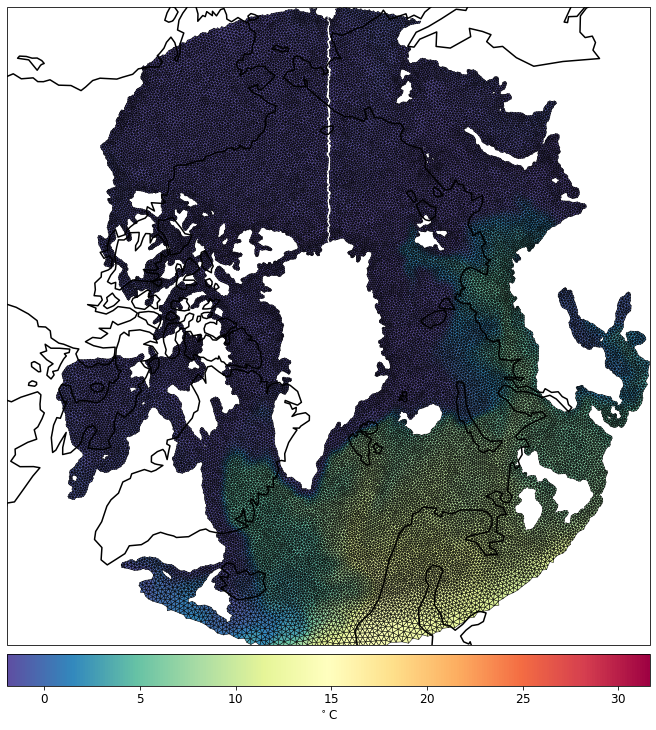

In [9]:
mesh = pf.load_mesh('/work/ollie/qigao001/startdump/mesh_CORE2_finaltopo_mean', abg=[50, 15, -90])
sst_fesom_pi_final_qg = xr.open_dataset('/work/ollie/qigao001/output/awiesm-2.1-wiso/pi_final_qg/analysis/fesom/sst.fesom.200001_202912.nc')

pf.tplot(
    mesh, sst_fesom_pi_final_qg.sst[0, ],
    ptype='tri', box=[-180, 180, 60, 90], mapproj='np', lw=0.5)
# plt.savefig('trial0.png')
